In [3]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
# 모델 분석 및 시각화 도구
import os, numpy as np, random
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import xml.etree.ElementTree as ET
import os
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns


# 모델 설계
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU, Flatten, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [5]:
import os
import numpy as np
from PIL import Image

# 데이터셋 경로
dataset_path = "/content/drive/MyDrive/ACK2025_Wafer/YOLO/cropped_objects"

# 클래스와 라벨 매핑
classes = {"Center": 0, "Donut": 1, "Edge-Loc": 2, "Edge-Ring": 3, "Loc": 4,
           "Near-full": 5, "Random": 6, "Scratch": 7}


# 폴더를 순회하며 이미지 로드 및 라벨링하는 함수 선언
def load_dataset(dataset_path, classes, img_size=(128,128)):
  image_data = []
  labels = []

  for class_name, label in classes.items():
    class_folder = os.path.join(dataset_path, class_name)
    for file in os.listdir(class_folder):
      image_path = os.path.join(class_folder, file)

      # 이미지 로드 (필요에 따라 리사이즈)
      try:
          img = Image.open(image_path).convert("RGB")
          img = img.resize((128, 128))
          image_data.append(np.array(img))
          labels.append(label)
      except Exception as e:
          print(f"이미지 로드 실패: {image_path}, 오류: {e}")

  return np.array(image_data), np.array(labels)


# 배열로 변환
X, y = load_dataset(dataset_path, classes)

# 클래스별 분포 출력
print(f"총 이미지 수 : {len(X)}")
print("클래스별 분포:")

# 라벨별 개수
unique, counts = np.unique(y, return_counts=True)

# 클래스명 역매핑
id_to_class = {v: k for k, v in classes.items()}

# 정렬 출력
for label, count in zip(unique, counts):
    name = id_to_class[int(label)]
    print(f"{name:<12}: {count}")


총 이미지 수 : 6987
클래스별 분포:
Center      : 960
Donut       : 541
Edge-Loc    : 981
Edge-Ring   : 999
Loc         : 1069
Near-full   : 150
Random      : 865
Scratch     : 1422


In [6]:
# 데이터 증강
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 가장 많은 클래스 기준으로 증강
class_counts = dict(zip(*np.unique(y, return_counts=True)))
max_count = max(class_counts.values())

X_aug, y_aug = [], []

# 클래스 증강
for class_label in np.unique(y):
    class_images = X[y == class_label]
    needed = max_count - len(class_images)
    if needed > 0:
        for img in class_images:
            img = img.reshape((1, *img.shape))
            for batch in datagen.flow(img, batch_size=1):
                X_aug.append(batch[0])
                y_aug.append(class_label)
                if len([l for l in y_aug if l == class_label]) >= needed:
                    break

# 증강된 데이터 합치기
X_bal = np.concatenate([X, np.array(X_aug)], axis=0)
y_bal = np.concatenate([y, np.array(y_aug)], axis=0)
X_bal, y_bal = shuffle(X_bal, y_bal, random_state=42)

print(f"📊 증강 후 총 이미지 수: {len(X_bal)}")
id_to_class = {v: k for k, v in classes.items()}
for label, count in zip(*np.unique(y_bal, return_counts=True)):
    print(f"{id_to_class[int(label)]:<12}: {count}")

📊 증강 후 총 이미지 수: 16934
Center      : 2381
Donut       : 1962
Edge-Loc    : 2402
Edge-Ring   : 2420
Loc         : 2490
Near-full   : 1571
Random      : 2286
Scratch     : 1422


In [7]:
# 정규화 (0 ~ 1)
X_bal = X_bal / 255.0
y_bal_cat = to_categorical(y_bal)

X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal_cat, test_size=0.2, random_state=42, stratify=y_bal)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (13547, 128, 128, 3), y_train: (13547, 8)
X_test: (3387, 128, 128, 3), y_test: (3387, 8)


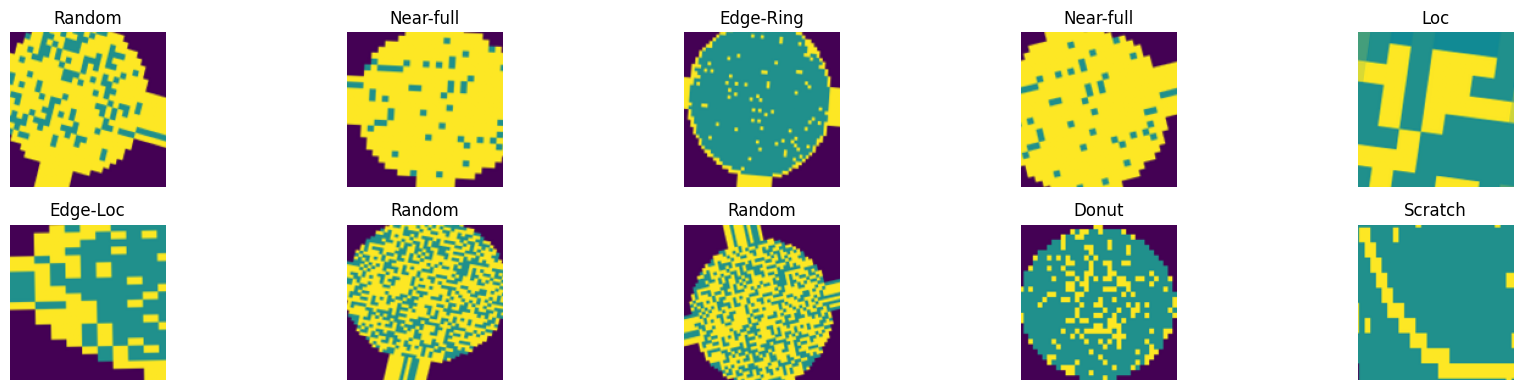

In [8]:
from tensorflow.keras.callbacks import EarlyStopping


import matplotlib.pyplot as plt
import random
import numpy as np

def visualize_images(X, y, label_map, num=10):
    assert len(X) == len(y), "X와 y의 길이가 일치해야 합니다."
    num = min(num, len(X))  # 데이터 수보다 많은 이미지 요청 방지

    indices = random.sample(range(len(X)), num)
    plt.figure(figsize=(num * 1.8, 4))  # 이미지 수에 따라 크기 조절

    for i, idx in enumerate(indices):
        img = X[idx]
        label_index = np.argmax(y[idx]) if y.ndim > 1 else y[idx]
        label_name = label_map.get(int(label_index), "Unknown")

        plt.subplot(2, (num + 1) // 2, i + 1)
        plt.imshow(img)
        plt.title(label_name)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_images(X_train, y_train,{v: k for k, v in classes.items()})

In [9]:
# 모델 결과 시각화 함수
def plot_history(history, main_title):
    plt.figure(figsize=(12, 5))

    # 전체 타이틀
    plt.suptitle(main_title, fontsize=20, fontweight='bold')

    # 정확도
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()

    # 손실
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.92])  # 전체 타이틀 공간 확보
    plt.show()

# 조기 종료 콜백 정의
early_stopping = EarlyStopping(
    monitor='val_loss',   # 검증 손실을 모니터링
    patience=10,           # 개선이 없을 때 대기할 에포크 수
    restore_best_weights=True  # 최적의 가중치를 복원
)

In [14]:
# 모델 구성
model_multi = Sequential([
    Flatten(input_shape=(128, 128, 3)),  # 3D 데이터를 1D로 변환
    Dense(128, activation='relu'),
    Dense(8, activation='softmax')      # 다중 클래스 분류용 추력층
])

model_multi.summary()

# 모델 학습 설정
model_multi.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
hist = model_multi.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]  # 조기 종료 콜백 추가
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     6,291,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,292,616 (24.00 MB)

 Trainable params: 6,292,616 (24.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
847/847 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.4805 - loss: 8.0394 - val_accuracy: 0.6652 - val_loss: 1.1112
Epoch 2/50
847/847 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7499 - loss: 0.7425 - val_accuracy: 0.7806 - val_loss: 0.6302
Epoch 3/50
847/847 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7797 - loss: 0.6172 - val_accuracy: 0.7972 - val_loss: 0.5901
Epoch 4/50
847/847 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8038 - loss: 0.5972 - val_accuracy: 0.8403 - val_loss: 0.4999
Epoch 5/50
847/847 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8140 - loss: 0.5695 - val_accuracy: 0.8025 - val_loss: 0.6022
Epoch 6/50
847/847 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8117 - loss: 0.5470 - val_accuracy: 0.8267 - val_loss: 0.5522
Epoch 7/50
847/847 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8125 - loss: 0.5647 - val_accuracy: 0.8025 - val_loss: 0.5821
Epoch 8/50
847/847 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8208 - loss: 0.5347 - val_accuracy: 0.

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.8403


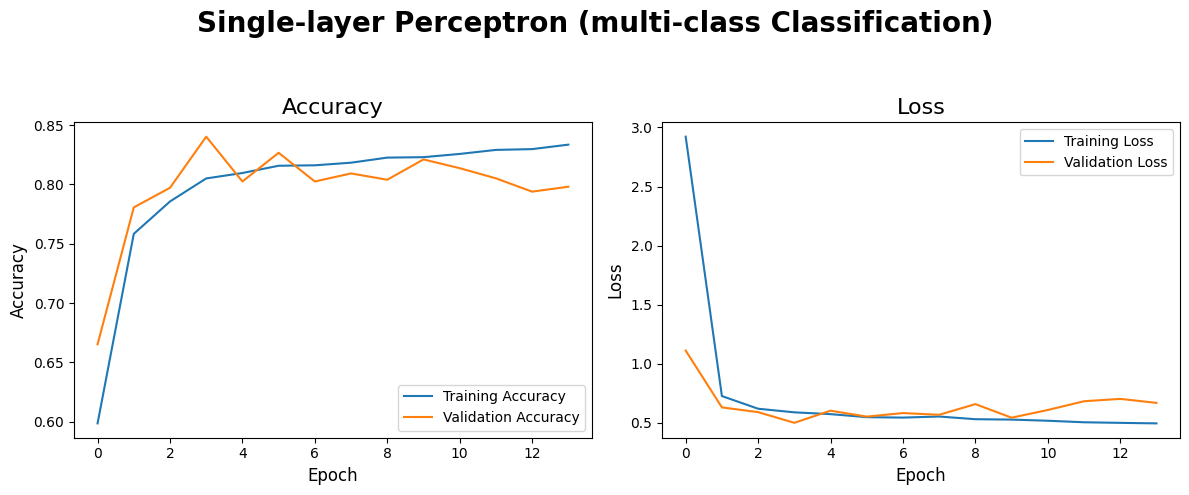

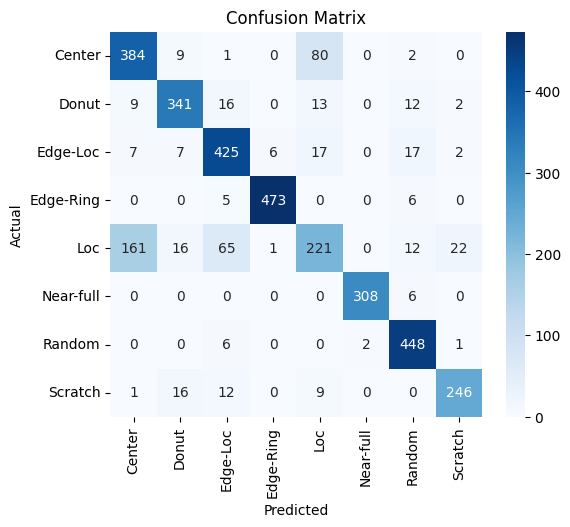

Classification Report:
              precision    recall  f1-score   support

      Center       0.68      0.81      0.74       476
       Donut       0.88      0.87      0.87       393
    Edge-Loc       0.80      0.88      0.84       481
   Edge-Ring       0.99      0.98      0.98       484
         Loc       0.65      0.44      0.53       498
   Near-full       0.99      0.98      0.99       314
      Random       0.89      0.98      0.93       457
     Scratch       0.90      0.87      0.88       284

    accuracy                           0.84      3387
   macro avg       0.85      0.85      0.85      3387
weighted avg       0.84      0.84      0.83      3387



In [18]:
# 예측값 (확률)
y_pred = model_multi.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# 정확도 계산
accuracy = accuracy_score(y_test_labels, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

# 학습 히스토리 시각화
plot_history(hist.history, "Single-layer Perceptron (multi-class Classification)")


# 혼동 행렬 계산
cm = confusion_matrix(y_test_labels, y_pred_classes)  # y_test와 y_pred_classes 비교

class_names = [k for k, _ in sorted(classes.items(), key=lambda x: x[1])]

# 혼동 행렬 시각화 (Seaborn Heatmap)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot = True, fmt='d',cmap='Blues',xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 리포트 출력
report = classification_report(y_test_labels, y_pred_classes, target_names=class_names)
print("Classification Report:")
print(report)